In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')

env.call('../002_design_optics/quad_strength_limits.py')
env.call('../002_design_optics/matching_constraints.py')

In [4]:
line = -env['ccs_yl']

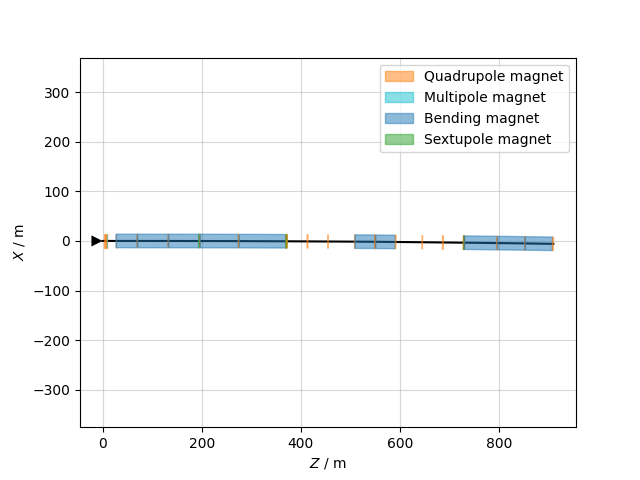

In [5]:
line.survey().plot()

### Section definitions
We identify four sub-sections of the CCS-Y (Final focus quads + Section A, B, C)
We want to create suitable optics conditions at the locations of the three sextupoles (sd*) that we will use to correct vertical chromaticity and related abberrations.

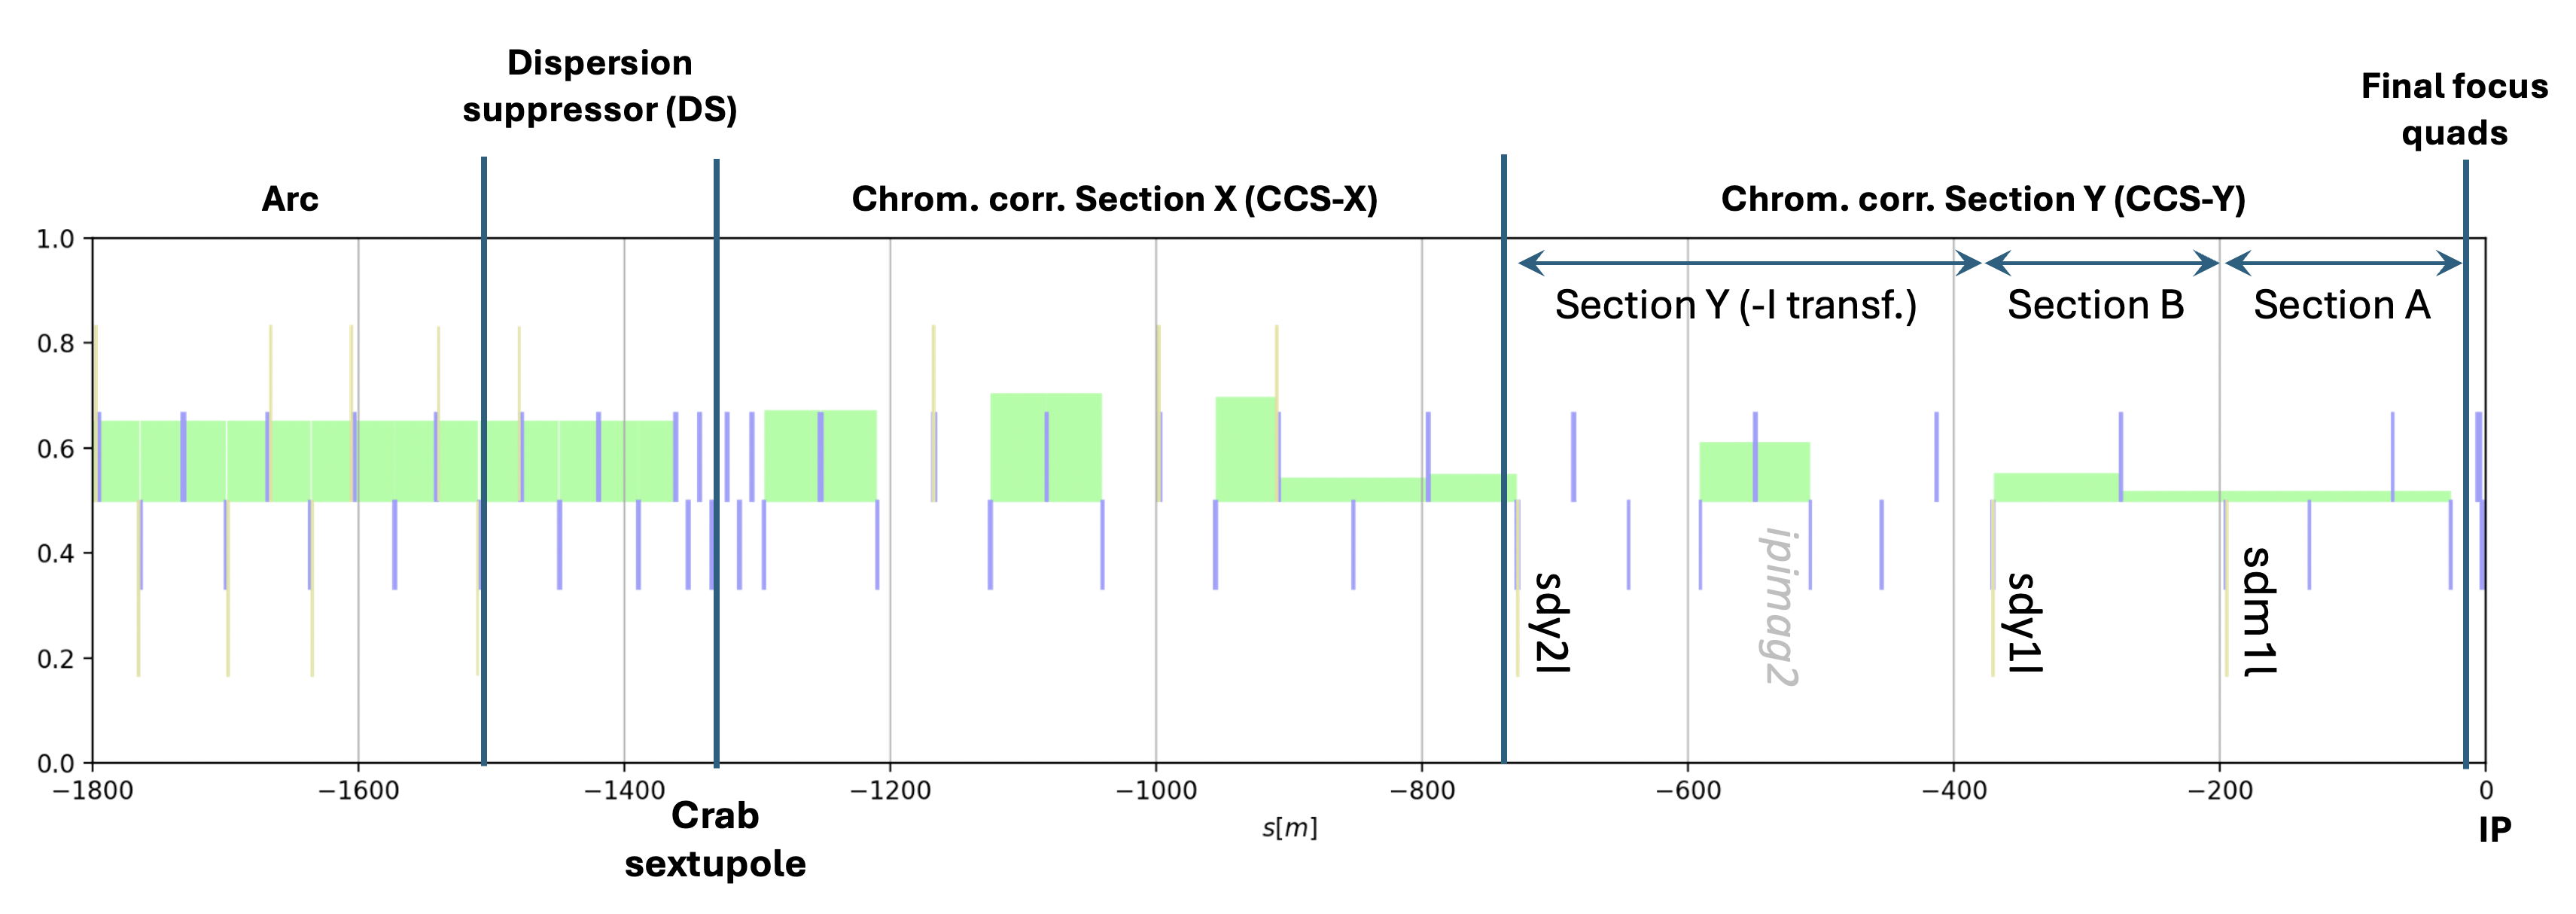

In [6]:
# Variables controlling quad strengths in each sections
kq_doublet = ['kqd0al', 'kqd0bl', 'kqf1al']
kq_section_a = ['kqd01l', 'kqf02l', 'kqd02l']
kq_section_b = ['kqd04l', 'kqf05l', 'kqd06l']
kq_yquads = ['kqy01l', 'kqy02l', 'kqy03l', 'kqy04l']

In [7]:
# Initialize quadrupoles with a small strength
for nn in kq_doublet + kq_section_a + kq_section_b +kq_yquads:
    if line.vars.vary_default[nn]['limits'][1] > 1e-3: # Focusing quad
        line[nn] = 1e-3
    else: # Defocusing quad
        line[nn] = -1e-3

### Shape beta functions of the final focus doublet

In [8]:
opt_doublet = line.match(
    name='doublet',
    solve=False,
    betx=env['bxip'], # initial beta x
    bety=env['byip'], # initial beta y
    default_tol=1e-5,
    targets=[
        # Peak in the doublet
        xt.TargetSet(bety=xt.LessThan(8550), at='qd0bl'),
        # Doublet exit
        xt.TargetSet(bety=xt.LessThan(3500), at='qf1bl'),
        xt.TargetSet(bety=xt.GreaterThan(3300), at='qf1bl'),
        # First quadrupole downstream
        xt.TargetSet(betx=xt.GreaterThan(1300), at='qd1l'),
        xt.TargetSet(betx=xt.LessThan(1400), at='qd1l'),
        xt.TargetSet(bety=xt.LessThan(3200), at='qd1l'),
        xt.TargetSet(bety=xt.GreaterThan(3100), at='qd1l'),
    ],
    vary = xt.VaryList(kq_doublet, step=1e-8)
)
opt = opt_doublet

In [9]:
# Targets before optimization
opt.target_status()

Target status:               alty = 1.0039e+06              
id state tag        tol_met       residue   current_val target_val        description                                 
0  ON    qd0bl_bety   False        -15405         23955 LessThan(8550)    ('bety', 'qd0bl'), val=LessThan(8550), t ...
1  ON    qf1bl_bety   False        -80267         83767 LessThan(3500)    ('bety', 'qf1bl'), val=LessThan(3500), t ...
2  ON    qf1bl_bety    True             0         83767 GreaterThan(3300) ('bety', 'qf1bl'), val=GreaterThan(3300) ...
3  ON    qd1l_betx     True             0       6755.96 GreaterThan(1300) ('betx', 'qd1l'), val=GreaterThan(1300), ...
4  ON    qd1l_betx    False      -5355.96       6755.96 LessThan(1400)    ('betx', 'qd1l'), val=LessThan(1400), to ...
5  ON    qd1l_bety    False  -1.00057e+06   1.00377e+06 LessThan(3200)    ('bety', 'qd1l'), val=LessThan(3200), to ...
6  ON    qd1l_bety     True             0   1.00377e+06 GreaterThan(3100) ('bety', 'qd1l'), val=GreaterTha

In [10]:
# Solve
opt.run_jacobian(100)

                                             
Optimize [doublet] - start penalty: 1.004e+06                         
Matching: model call n. 46 penalty = 0.0000e+00              
Optimize [doublet] - end penalty:     0                            


In [11]:
# Targets after optimization
opt.target_status()

Target status:               nalty = 0.0000e+00              
id state tag        tol_met       residue   current_val target_val        description                                 
0  ON    qd0bl_bety    True             0       8102.49 LessThan(8550)    ('bety', 'qd0bl'), val=LessThan(8550), t ...
1  ON    qf1bl_bety    True             0       3499.99 LessThan(3500)    ('bety', 'qf1bl'), val=LessThan(3500), t ...
2  ON    qf1bl_bety    True             0       3499.99 GreaterThan(3300) ('bety', 'qf1bl'), val=GreaterThan(3300) ...
3  ON    qd1l_betx     True             0          1300 GreaterThan(1300) ('betx', 'qd1l'), val=GreaterThan(1300), ...
4  ON    qd1l_betx     True             0          1300 LessThan(1400)    ('betx', 'qd1l'), val=LessThan(1400), to ...
5  ON    qd1l_bety     True             0       3199.95 LessThan(3200)    ('bety', 'qd1l'), val=LessThan(3200), to ...
6  ON    qd1l_bety     True             0       3199.95 GreaterThan(3100) ('bety', 'qd1l'), val=GreaterTh

(<xtrack.twissplot.TwissPlot object at 0x3402306d0>,
 <xtrack.twissplot.TwissPlot object at 0x3402306d0>)

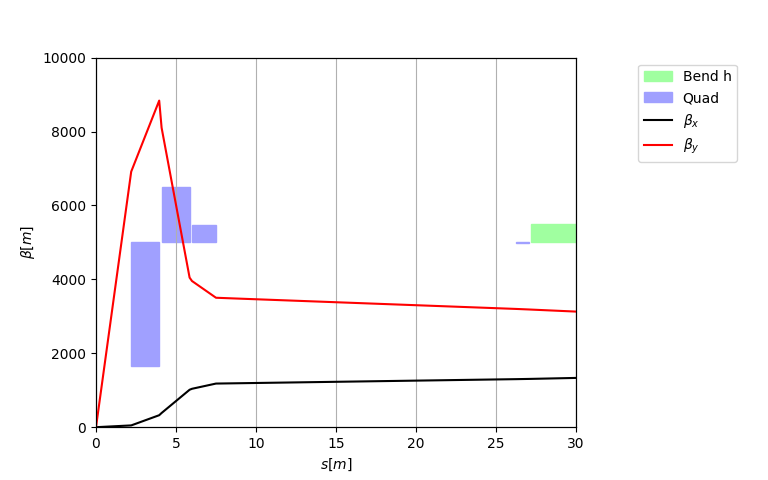

In [12]:
# Plot
pp=opt.plot('betx bety')
pp.xlim(0, 30), pp.ylim(left_lo=0, left_hi=10000)

### Match section A (up to the first sextupole - sdm1l)

In [13]:
# We build the optimizer as a clone
opt_section_a = opt_doublet.clone(
    name='section_a',
    remove_vary=True, remove_targets=True,
    add_targets=[
        xt.TargetSet(alfx=xt.GreaterThan(-1.), alfy=0.0,
                     betx=xt.LessThan(10.), bety=xt.LessThan(12.),
                     at='sdm1l::0'),
        xt.TargetSet(betx=xt.LessThan(3000), at='qf2l'),
        xt.TargetSet(bety=xt.GreaterThan(900), at='qf2l'),
    ], 
    add_vary=xt.VaryList(kq_section_a, step=1e-8),
)
opt = opt_section_a

In [14]:
opt.run_jacobian(100)

                                             
Optimize [section_a] - start penalty: 3079                         
Matching: model call n. 756 penalty = 6.2921e-01              
Optimize [section_a] - end penalty:  0.629214                            


In [15]:
opt.target_status()

Target status:               enalty = 6.2921e-01              
id state tag           tol_met       residue   current_val target_val       description                                 
0  ON    sdm1l::0_betx   False     -0.629032        10.629 LessThan(10)     ('betx', 'sdm1l::0'), val=LessThan(10),  ...
1  ON    sdm1l::0_bety    True             0       6.50848 LessThan(12)     ('bety', 'sdm1l::0'), val=LessThan(12),  ...
2  ON    sdm1l::0_alfx    True             0    -0.0888454 GreaterThan(-1)  ('alfx', 'sdm1l::0'), val=GreaterThan(-1 ...
3  ON    sdm1l::0_alfy   False  -0.000808836  -0.000808836 0.0              ('alfy', 'sdm1l::0'), val=0, tol=1e-05,  ...
4  ON    qf2l_betx        True             0       2824.22 LessThan(3000)   ('betx', 'qf2l'), val=LessThan(3000), to ...
5  ON    qf2l_bety       False    -0.0128127       899.987 GreaterThan(900) ('bety', 'qf2l'), val=GreaterThan(900),  ...


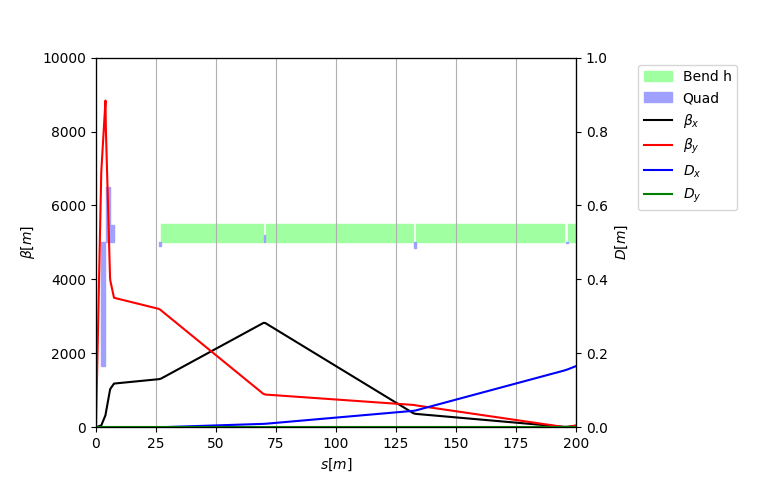

In [16]:
pp=opt.plot()
pp.xlim(0, 200); pp.ylim(0, 1e4, 0, 1)

### Match section B (up to second sextupole `sdy1l::1`)

In [17]:
# First we use only quadrupoles in section B
opt_section_b = opt_section_a.clone(
    name='section_b', 
    remove_targets=True, remove_vary=True,
    add_targets=xt.TargetSet(at='sdy1l::1',
        bety=8114.3, betx=371.7,
        alfy=0., 
        dx=xt.GreaterThan(0.3),
        muy=0.75 + env['dmuy_sdy1l'] # <--- need a controlled phase of the sextupole to the IP
        ),
    add_vary=xt.VaryList(kq_section_b, step=1e-8))
opt = opt_section_b
opt.run_jacobian(100)

                                             
Optimize [section_b] - start penalty: 3491                         
Matching: model call n. 695 penalty = 1.0066e+03              
Optimize [section_b] - end penalty:  1006.64                            


In [18]:
# Quadrupoles in section B are not enough to reach the target
opt.target_mismatch() # shows only targets that are not matched

Target mismatch:             enalty = 1.0066e+03              
id state tag           tol_met       residue   current_val target_val description                                 
0  ON    sdy1l::1_betx   False       950.435       1322.13 371.7      ('betx', 'sdy1l::1'), val=371.7, tol=1e- ...
1  ON    sdy1l::1_bety   False       330.762       8445.06 8114.3     ('bety', 'sdy1l::1'), val=8114.3, tol=1e ...
2  ON    sdy1l::1_alfy   False       2.42497       2.42497 0.0        ('alfy', 'sdy1l::1'), val=0, tol=1e-05,  ...
3  ON    sdy1l::1_muy    False    0.00767613      0.757591 0.749915   ('muy', 'sdy1l::1'), val=0.749915, tol=1 ...


In [19]:
# I use also the quadrupoles in section A, making sure I preserve the
# conditions that I had previously matched at the exit of Section A
opt_sections_ab = opt_section_b.clone(name='sections_ab',
                    add_vary=opt_section_a.vary,
                    add_targets=opt_section_a.targets)
opt = opt_sections_ab

In [20]:
opt.run_jacobian(50)

                                             
Optimize [sections_ab] - start penalty: 1007                         
Matching: model call n. 547 penalty = 4.3305e+01              
Optimize [sections_ab] - end penalty:  43.3052                            


In [21]:
# Inspect
opt.target_status()

Target status:               enalty = 4.3305e+01              
id state tag           tol_met       residue   current_val target_val       description                                 
0  ON    sdy1l::1_betx   False       41.6983       413.398 371.7            ('betx', 'sdy1l::1'), val=371.7, tol=1e- ...
1  ON    sdy1l::1_bety   False       1.59013       8115.89 8114.3           ('bety', 'sdy1l::1'), val=8114.3, tol=1e ...
2  ON    sdy1l::1_alfy   False     -0.589257     -0.589257 0.0              ('alfy', 'sdy1l::1'), val=0, tol=1e-05,  ...
3  ON    sdy1l::1_muy    False     0.0750435      0.824958 0.749915         ('muy', 'sdy1l::1'), val=0.749915, tol=1 ...
4  ON    sdy1l::1_dx      True             0       1.08545 GreaterThan(0.3) ('dx', 'sdy1l::1'), val=GreaterThan(0.3) ...
5  ON    sdm1l::0_betx   False      -7.57759       17.5776 LessThan(10)     ('betx', 'sdm1l::0'), val=LessThan(10),  ...
6  ON    sdm1l::0_bety    True             0       8.31806 LessThan(12)     ('bety', 'sdm1

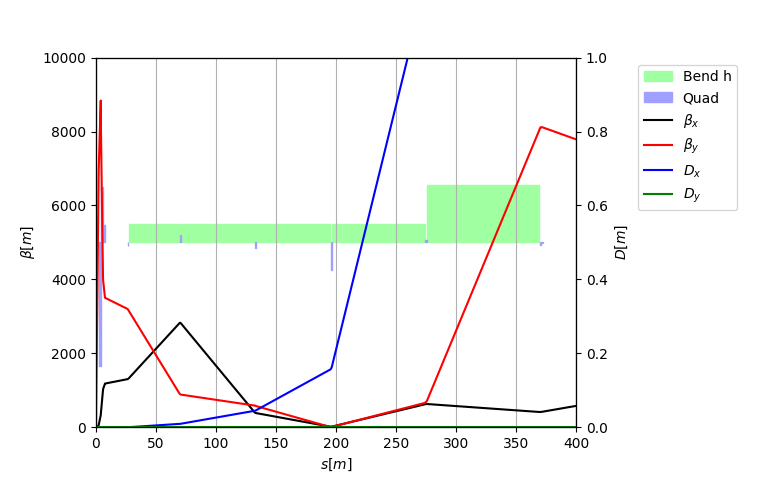

In [22]:
# Plot
pp = opt.plot()
pp.xlim(0, 400); pp.ylim(0, 1e4, 0, 1)

### Match section Y (create -I transformation between `sdy1l` and `sdy2l`)

In [23]:
opt_section_y = line.match(
    name='section_y',
    solve=False,
    start='sdy1l::1', end='sdy2l::1', init_at='ipimag2',
    betx=135, bety=10, # Rough estimate
    targets=xt.TargetRmatrix(start='sdy1l::1', end='sdy2l::1',
                r12=env['r12_ccsyl'], r34=env['r34_ccsyl'],
                r33=-1.0, r43=0.0, 
                tol=1e-6),
    vary=xt.VaryList(kq_yquads, step=1e-8)
)
opt = opt_section_y
opt.target_status()

Target status:               alty = 5.0200e+02              
id state tag tol_met       residue   current_val    target_val description                                 
0  ON    r12   False       346.716       346.621        -0.095 r12(sdy1l::1, sdy2l::1, val=-0.095, tol= ...
1  ON    r33   False       1.97242       0.97242            -1 r33(sdy1l::1, sdy2l::1, val=-1.0, tol=1e ...
2  ON    r34   False        363.03       362.935        -0.095 r34(sdy1l::1, sdy2l::1, val=-0.095, tol= ...
3  ON    r43   False   -0.00015001   -0.00015001             0 r43(sdy1l::1, sdy2l::1, val=0.0, tol=1e- ...


In [24]:
# This optimization is tough to converge, we introduce targets one at a time

In [25]:
opt.disable(target=True)
opt.target_status()

Target status:               alty = 0.0000e+00              
id state tag tol_met       residue   current_val    target_val description                                 
0  OFF   r12   False       346.716       346.621        -0.095 r12(sdy1l::1, sdy2l::1, val=-0.095, tol= ...
1  OFF   r33   False       1.97242       0.97242            -1 r33(sdy1l::1, sdy2l::1, val=-1.0, tol=1e ...
2  OFF   r34   False        363.03       362.935        -0.095 r34(sdy1l::1, sdy2l::1, val=-0.095, tol= ...
3  OFF   r43   False   -0.00015001   -0.00015001             0 r43(sdy1l::1, sdy2l::1, val=0.0, tol=1e- ...


In [26]:
opt.enable(target='r12')
opt.run_jacobian(20)
opt.target_status()

                                             
Optimize [section_y] - start penalty: 346.7                         
Matching: model call n. 33 penalty = 1.4636e-06              
Optimize [section_y] - end penalty:  1.46356e-06                            
Target status:               nalty = 1.4636e-06              
id state tag tol_met       residue   current_val    target_val description                                 
0  ON    r12    True   1.46356e-06    -0.0949985        -0.095 r12(sdy1l::1, sdy2l::1, val=-0.095, tol= ...
1  OFF   r33   False       8.87057       7.87057            -1 r33(sdy1l::1, sdy2l::1, val=-1.0, tol=1e ...
2  OFF   r34   False       1057.34       1057.25        -0.095 r34(sdy1l::1, sdy2l::1, val=-0.095, tol= ...
3  OFF   r43   False     0.0577749     0.0577749             0 r43(sdy1l::1, sdy2l::1, val=0.0, tol=1e- ...


In [27]:
opt.enable(target='r33')
opt.run_jacobian(20)
opt.target_status()

                                             
Optimize [section_y] - start penalty: 8.871                         
Matching: model call n. 72 penalty = 6.5278e-07              
Optimize [section_y] - end penalty:  6.52782e-07                            
Target status:               nalty = 6.5278e-07              
id state tag tol_met       residue   current_val    target_val description                                 
0  ON    r12    True  -6.47777e-07    -0.0950006        -0.095 r12(sdy1l::1, sdy2l::1, val=-0.095, tol= ...
1  ON    r33    True   8.06818e-08            -1            -1 r33(sdy1l::1, sdy2l::1, val=-1.0, tol=1e ...
2  OFF   r34   False       436.823       436.728        -0.095 r34(sdy1l::1, sdy2l::1, val=-0.095, tol= ...
3  OFF   r43    True  -3.69229e-10  -3.69229e-10             0 r43(sdy1l::1, sdy2l::1, val=0.0, tol=1e- ...


In [28]:
opt.enable(target='r34')
opt.run_jacobian(20)
opt.enable(target='r43')
opt.run_jacobian(20)
opt.target_status()

                                             
Optimize [section_y] - start penalty: 436.8                         
Matching: model call n. 117 penalty = 8.0257e-06              
Optimize [section_y] - end penalty:  8.02566e-06                            
                                             
Optimize [section_y] - start penalty: 8.044e-06                         
Matching: model call n. 124 penalty = 2.9166e-09              
Optimize [section_y] - end penalty:  2.91659e-09                            
Target status:               enalty = 2.9166e-09              
id state tag tol_met       residue   current_val    target_val description                                 
0  ON    r12    True  -2.25594e-09        -0.095        -0.095 r12(sdy1l::1, sdy2l::1, val=-0.095, tol= ...
1  ON    r33    True  -1.71863e-13            -1            -1 r33(sdy1l::1, sdy2l::1, val=-1.0, tol=1e ...
2  ON    r34    True  -1.84857e-09        -0.095        -0.095 r34(sdy1l::1, sdy2l::1, val=-0.095, 

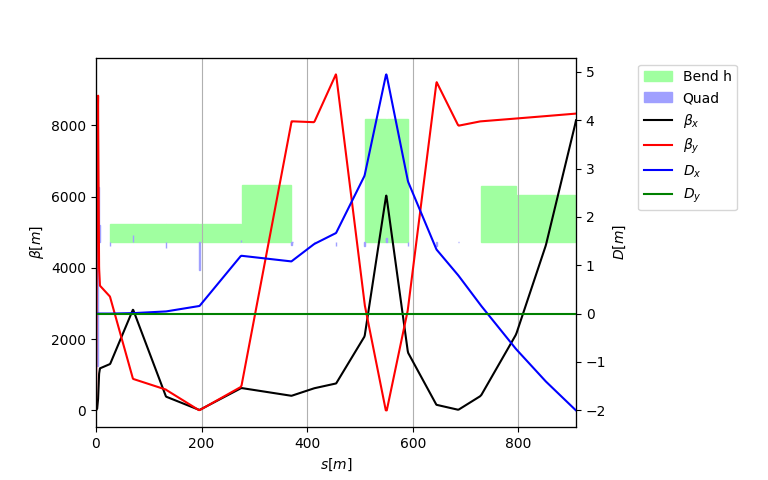

In [29]:
opt_section_b.plot()

### Control beta end dispersion at IP image point
(preserving all conditions matched so far)

In [30]:
opt_imag2 = line.match(
    solve=False,
    name='imag2',
    betx=env['bxip'],
    bety=env['byip'],
    default_tol=1e-5,
    vary=[
        xt.VaryList(kq_section_a, tag='section_a', step=1e-8),
        xt.VaryList(kq_section_b, tag='section_b', step=1e-8),
        xt.VaryList(kq_yquads, tag='section_y', step=1e-8)],
    targets=list(opt_section_a.targets['sdm1l.*'])
          + list(opt_section_b.targets)
          + list(opt_section_y.targets) 
          + [xt.TargetSet(at='ipimag2',
                betx=xt.GreaterThan(60.),
                alfx=0., alfy=0.,
                dx=0.302, dpx=0)]
)
opt = opt_imag2

In [31]:
opt.target_status()

Target status:               alty = 8.0891e+01              
id state tag           tol_met       residue   current_val target_val       description                                 
0  ON    sdm1l::0_betx   False      -7.57759       17.5776 LessThan(10)     ('betx', 'sdm1l::0'), val=LessThan(10),  ...
1  ON    sdm1l::0_bety    True             0       8.31806 LessThan(12)     ('bety', 'sdm1l::0'), val=LessThan(12),  ...
2  ON    sdm1l::0_alfx    True             0      0.591536 GreaterThan(-1)  ('alfx', 'sdm1l::0'), val=GreaterThan(-1 ...
3  ON    sdm1l::0_alfy   False     -0.638353     -0.638353 0.0              ('alfy', 'sdm1l::0'), val=0, tol=1e-05,  ...
4  ON    sdy1l::1_betx   False       41.6983       413.398 371.7            ('betx', 'sdy1l::1'), val=371.7, tol=1e- ...
5  ON    sdy1l::1_bety   False       1.59013       8115.89 8114.3           ('bety', 'sdy1l::1'), val=8114.3, tol=1e ...
6  ON    sdy1l::1_alfy   False     -0.589257     -0.589257 0.0              ('alfy', 'sdy1l:

In [32]:
opt.run_jacobian(100)

                                             
Optimize [imag2] - start penalty: 80.89                         
Matching: model call n. 501 penalty = 1.1830e-04              
Optimize [imag2] - end penalty:  0.0001183                            


In [33]:
opt.target_status()

Target status:               enalty = 1.1830e-04              
id state tag           tol_met       residue   current_val target_val       description                                 
0  ON    sdm1l::0_betx    True             0       8.43103 LessThan(10)     ('betx', 'sdm1l::0'), val=LessThan(10),  ...
1  ON    sdm1l::0_bety    True             0       10.5617 LessThan(12)     ('bety', 'sdm1l::0'), val=LessThan(12),  ...
2  ON    sdm1l::0_alfx    True             0    -0.0585173 GreaterThan(-1)  ('alfx', 'sdm1l::0'), val=GreaterThan(-1 ...
3  ON    sdm1l::0_alfy    True  -3.80426e-09  -3.80426e-09 0.0              ('alfy', 'sdm1l::0'), val=0, tol=1e-05,  ...
4  ON    sdy1l::1_betx    True  -7.16746e-08         371.7 371.7            ('betx', 'sdy1l::1'), val=371.7, tol=1e- ...
5  ON    sdy1l::1_bety    True   1.25328e-09        8114.3 8114.3           ('bety', 'sdy1l::1'), val=8114.3, tol=1e ...
6  ON    sdy1l::1_alfy    True   9.72214e-11   9.72214e-11 0.0              ('alfy', 'sdy1

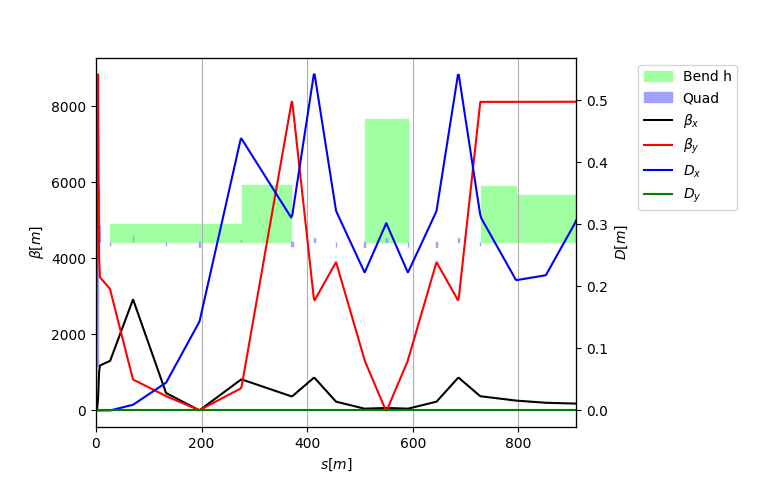

In [34]:
opt.plot()

### Save strengths

In [35]:
# Extract a dictionary with all quad strnstrs that we have matched
tt_vars = line.vars.get_table()
tt_out = tt_vars.rows[kq_doublet + kq_section_a + kq_section_b + kq_yquads]

In [36]:
tt_out.to_pandas()

,name,value,expr
0,kqd0al,-0.374920,None
1,kqd0bl,0.168721,None
2,kqf1al,0.051973,None
3,kqd01l,-0.011159,None
4,kqf02l,0.021668,None
5,kqd02l,-0.010378,None
6,kqd04l,-0.013206,None
7,kqf05l,0.009907,None
8,kqd06l,-0.009590,None
9,kqy01l,-0.012214,None


In [37]:
# Save to json
ddd = tt_out.to_dict()
xt.json.dump(ddd, 'strengths_quads_01_ffccsyl.json')

In [38]:
# Inspect
!cat strengths_quads_01_ffccsyl.json

{
 "kqd0al": -0.3749202541877432,
 "kqd0bl": 0.16872137330748618,
 "kqf1al": 0.051973133099463185,
 "kqd01l": -0.011158765533079212,
 "kqf02l": 0.02166845820269564,
 "kqd02l": -0.010378212081440848,
 "kqd04l": -0.01320625180684508,
 "kqf05l": 0.009907340895694908,
 "kqd06l": -0.00958991340798639,
 "kqy01l": -0.012214333661632786,
 "kqy02l": 0.012644389734380422,
 "kqy03l": -0.013904443748403342,
 "kqy04l": 0.013479771548588485
}